In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

def load_and_prepare_data():
	"""
    Load and prepare Formula 1 datasets for model training
    """
	# Load datasets
	circuits = pd.read_csv("data/circuits.csv", encoding="ISO-8859-1").drop(columns=['url'])
	constructors = pd.read_csv("data/constructors.csv").drop(columns=['url'])
	drivers = pd.read_csv("data/drivers.csv", encoding="ISO-8859-1").drop(columns=['url'])
	races = pd.read_csv("data/races.csv").drop(columns=['url'])
	results = pd.read_csv("data/results.csv")
	lap_times = pd.read_csv("data/lapTimes.csv")
	pit_stops = pd.read_csv("data/pitStops.csv")
	qualifying = pd.read_csv("data/qualifying.csv")

	# Date parsing
	drivers['dob'] = pd.to_datetime(drivers['dob'], format='%d/%m/%Y', errors='coerce')
	races['date'] = pd.to_datetime(races['date'], errors='coerce')

	# Process lap times
	lap_stats = lap_times.groupby(['raceId', 'driverId']).agg({
		'milliseconds': ['mean', 'std', 'min'],  # Average lap time, consistency, and best lap
		'position': ['mean', 'std']  # Average position and position changes
	}).reset_index()
	lap_stats.columns = ['raceId', 'driverId', 'avg_lap_time', 'lap_time_std',
						 'best_lap_time', 'avg_position', 'position_std']

	# Process pit stops with default values for missing data
	# First, create a template of all race-driver combinations
	race_driver_combinations = results[['raceId', 'driverId']].drop_duplicates()

	# Calculate pit stop statistics where they exist
	pit_stats = pit_stops.groupby(['raceId', 'driverId']).agg({
		'milliseconds': ['mean', 'count'],  # Average pit time and number of stops
	}).reset_index()
	pit_stats.columns = ['raceId', 'driverId', 'avg_pit_time', 'pit_stop_count']

	# Merge with template to ensure all races have entries
	pit_stats = race_driver_combinations.merge(
		pit_stats,
		on=['raceId', 'driverId'],
		how='left'
	)

	# Fill missing values with meaningful defaults
	pit_stats['pit_stop_count'] = pit_stats['pit_stop_count'].fillna(0)
	pit_stats['avg_pit_time'] = pit_stats['avg_pit_time'].fillna(0)  # 0 indicates no pit stops

	# Process qualifying
	def time_to_ms(time_str):
		if pd.isna(time_str) or time_str == "":
			return np.nan
		try:
			minutes, seconds = time_str.split(':')
			return float(minutes) * 60000 + float(seconds) * 1000
		except:
			return np.nan

	for q in ['q1', 'q2', 'q3']:
		qualifying[f'{q}_ms'] = qualifying[q].apply(time_to_ms)

	qual_stats = qualifying.groupby(['raceId', 'driverId']).agg({
		'position': 'first',  # Qualifying position
		'q1_ms': 'first',     # Q1 time
		'q2_ms': 'first',     # Q2 time
		'q3_ms': 'first'      # Q3 time
	}).reset_index()

	# Merge datasets
	merged_data = results.merge(races[['raceId', 'year', 'circuitId']], on='raceId')
	merged_data = merged_data.merge(drivers[['driverId', 'dob', 'nationality']], on='driverId')
	merged_data = merged_data.merge(constructors[['constructorId', 'name', 'nationality']], on='constructorId')
	merged_data = merged_data.merge(circuits[['circuitId', 'name', 'country']], on='circuitId')
	merged_data = merged_data.merge(lap_stats, on=['raceId', 'driverId'], how='left')
	merged_data = merged_data.merge(pit_stats, on=['raceId', 'driverId'], how='left')
	merged_data = merged_data.merge(qual_stats, on=['raceId', 'driverId'], how='left')

	# Feature engineering
	merged_data['driver_age'] = merged_data['year'] - merged_data['dob'].dt.year
	merged_data['qual_to_race_pos_change'] = merged_data['position_y'] - merged_data['position_x']

	# Add pit stop related features that handle missing data
	merged_data['had_pit_stop'] = (merged_data['pit_stop_count'] > 0).astype(int)

	# Select features
	features = [
		# Original features
		'year', 'grid', 'driver_age',
		'constructorId', 'circuitId', 'nationality_x',

		# New features from lap times
		'avg_lap_time', 'lap_time_std', 'best_lap_time',
		'avg_position', 'position_std',

		# New features from pit stops
		'avg_pit_time', 'pit_stop_count', 'had_pit_stop',

		# New features from qualifying
		'position_y',  # Qualifying position
		'q1_ms', 'q2_ms', 'q3_ms',
		'qual_to_race_pos_change'
	]

	# Prepare X and y
	X = merged_data[features]
	y = merged_data['points']

	return X, y, merged_data

def create_preprocessing_pipeline():
	"""
    Create a comprehensive preprocessing pipeline with robust handling of missing values
    """
	# Numeric features
	numeric_features = [
		'year', 'grid', 'driver_age',
		'avg_lap_time', 'lap_time_std', 'best_lap_time',
		'avg_position', 'position_std',
		'avg_pit_time', 'pit_stop_count',
		'position_y', 'q1_ms', 'q2_ms', 'q3_ms',
		'qual_to_race_pos_change', 'had_pit_stop'
	]

	# Categorical features
	categorical_features = [
		'constructorId', 'circuitId',
		'nationality_x'
	]

	# Preprocessing for numeric features
	numeric_transformer = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Changed to constant imputation
		('scaler', StandardScaler())
	])

	# Preprocessing for categorical features
	categorical_transformer = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
		('onehot', OneHotEncoder(handle_unknown='ignore'))
	])

	# Combine preprocessing steps
	preprocessor = ColumnTransformer(
		transformers=[
			('num', numeric_transformer, numeric_features),
			('cat', categorical_transformer, categorical_features)
		])

	return preprocessor

def train_performance_prediction_model(test_size=0.2, random_state=42):
	"""
    Train and evaluate multiple models for F1 performance prediction
    """
	# Load and prepare data
	X, y, merged_data = load_and_prepare_data()

	# Split the data
	X_train, X_test, y_train, y_test = train_test_split(
		X, y, test_size=test_size, random_state=random_state
	)

	# Create preprocessing pipeline
	preprocessor = create_preprocessing_pipeline()

	# Define models to test
	models = {
		'Random Forest': RandomForestRegressor(n_estimators=100, random_state=random_state),
		'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=random_state)
	}

	# Results storage
	model_results = {}
	fitted_pipeline = None

	# Train and evaluate each model
	for name, model in models.items():
		# Create full pipeline
		pipeline = Pipeline([
			('preprocessor', preprocessor),
			('regressor', model)
		])

		# Train the model
		pipeline.fit(X_train, y_train)

		# Make predictions
		y_pred = pipeline.predict(X_test)

		# Evaluate the model
		mse = mean_squared_error(y_test, y_pred)
		r2 = r2_score(y_test, y_pred)
		mae = mean_absolute_error(y_test, y_pred)

		# Perform cross-validation
		cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

		# Store results
		model_results[name] = {
			'Mean Squared Error': mse,
			'R-squared': r2,
			'Mean Absolute Error': mae,
			'Cross-Validation R2': (cv_scores.mean(), cv_scores.std())
		}

		# Print results
		print(f"\n{name} Model Performance:")
		for metric, value in model_results[name].items():
			print(f"{metric}: {value}")

		fitted_pipeline = pipeline  # The last model that was trained

	return models, model_results, X_test, y_test, fitted_pipeline

def feature_importance(fitted_pipeline):
	"""
    Extract and print feature importances from a fitted pipeline
    """
	try:
		# Get the fitted regressor from the pipeline
		regressor = fitted_pipeline.named_steps['regressor']

		# Get the preprocessor from the pipeline
		preprocessor = fitted_pipeline.named_steps['preprocessor']

		# Get feature names after preprocessing
		feature_names = (
				preprocessor
				.named_transformers_['num'].get_feature_names_out().tolist() +
				preprocessor
				.named_transformers_['cat'].get_feature_names_out().tolist()
		)

		# Get feature importances
		importances = regressor.feature_importances_

		# Create a DataFrame of feature importances
		feature_importance_df = pd.DataFrame({
			'feature': feature_names,
			'importance': importances
		}).sort_values('importance', ascending=False)

		print("\nFeature Importances:")
		print(feature_importance_df)

		return feature_importance_df

	except Exception as e:
		print(f"Error extracting feature importances: {e}")
		return None


models, model_results, X_test, y_test, fitted_pipeline = train_performance_prediction_model()

# Extract feature importances
feature_importance(fitted_pipeline)


Random Forest Model Performance:
Mean Squared Error: 3.6859744159314554
R-squared: 0.6951189714638542
Mean Absolute Error: 0.947483158116064
Cross-Validation R2: (np.float64(0.3513968312804637), np.float64(0.14984320919811692))

Gradient Boosting Model Performance:
Mean Squared Error: 3.6303151388270325
R-squared: 0.6997227629546007
Mean Absolute Error: 1.0941594891735282
Cross-Validation R2: (np.float64(0.37015137619078997), np.float64(0.1169828469726337))

Feature Importances:
                      feature  importance
13                      q3_ms    0.320856
6                avg_position    0.271247
1                        grid    0.132965
14    qual_to_race_pos_change    0.087797
0                        year    0.043015
..                        ...         ...
122         constructorId_111    0.000000
121         constructorId_110    0.000000
120         constructorId_109    0.000000
118         constructorId_107    0.000000
326  nationality_x_Venezuelan    0.000000

[327 rows 

,feature,importance
13,q3_ms,0.320856
6,avg_position,0.271247
1,grid,0.132965
14,qual_to_race_pos_change,0.087797
0,year,0.043015
...,...,...
122,constructorId_111,0.000000
121,constructorId_110,0.000000
120,constructorId_109,0.000000
118,constructorId_107,0.000000


In [60]:
def make_prediction(fitted_pipeline, year, grid, constructor_id, circuit_id=1,
					driver_age=25, nationality='British', qualifying_position=None,
					avg_lap_time=85000, lap_time_std=1000, best_lap_time=84000,
					avg_position=None, position_std=2.0,
					pit_stops=1, avg_pit_time=23000,
					q1_time=85000, q2_time=84500, q3_time=84000):
	"""
    Make a prediction for a single race scenario with comprehensive race weekend data

    Parameters:
    -----------
    year: int
        Race year
    grid: int
        Starting position on the grid
    constructor_id: int
        ID of the constructor (team)
    circuit_id: int
        ID of the circuit
    driver_age: int
        Age of the driver
    nationality: str
        Nationality of the driver
    qualifying_position: int
        Final qualifying position (defaults to grid position if None)
    avg_lap_time: int
        Average lap time in milliseconds
    lap_time_std: float
        Standard deviation of lap times
    best_lap_time: int
        Best lap time in milliseconds
    avg_position: float
        Average race position (defaults to grid position if None)
    position_std: float
        Standard deviation of race positions
    pit_stops: int
        Number of pit stops
    avg_pit_time: int
        Average pit stop time in milliseconds
    q1_time, q2_time, q3_time: int
        Qualifying session times in milliseconds
    """
	# Set defaults for position-based metrics
	if qualifying_position is None:
		qualifying_position = grid
	if avg_position is None:
		avg_position = float(grid)

	# Calculate position change
	qual_to_race_pos_change = qualifying_position - grid

	# Create a sample input DataFrame
	sample_input = pd.DataFrame({
		'year': [year],
		'grid': [grid],
		'driver_age': [driver_age],
		'constructorId': [constructor_id],
		'circuitId': [circuit_id],
		'nationality_x': [nationality],

		# Lap time features
		'avg_lap_time': [avg_lap_time],
		'lap_time_std': [lap_time_std],
		'best_lap_time': [best_lap_time],
		'avg_position': [avg_position],
		'position_std': [position_std],

		# Pit stop features
		'avg_pit_time': [avg_pit_time],
		'pit_stop_count': [pit_stops],
		'had_pit_stop': [1 if pit_stops > 0 else 0],

		# Qualifying features
		'position_y': [qualifying_position],
		'q1_ms': [q1_time],
		'q2_ms': [q2_time],
		'q3_ms': [q3_time],
		'qual_to_race_pos_change': [qual_to_race_pos_change]
	})

	# Make prediction
	predicted_points = fitted_pipeline.predict(sample_input)
	return predicted_points[0]

def evaluate_predictions(fitted_pipeline, X_test, y_test, n_samples=10):
	"""
    Compare actual vs predicted values for a subset of the test data
    """
	# Store original feature values before pipeline transformation
	original_features = X_test.copy()

	# Get predictions for test set
	y_pred = fitted_pipeline.predict(X_test)

	# Create comparison DataFrame
	comparison = pd.DataFrame({
		'Actual Points': y_test,
		'Predicted Points': y_pred,
		'Difference': abs(y_test - y_pred),
		'Year': original_features['year'],
		'Grid': original_features['grid'],
		'Constructor': original_features['constructorId'],
		'Circuit': original_features['circuitId'],
		'Driver Age': original_features['driver_age'],
		'Qualifying Position': original_features['position_y'],
		'Pit Stops': original_features['pit_stop_count'],
		'Avg Pit Time': original_features['avg_pit_time'].round(3),
		'Avg Lap Time': original_features['avg_lap_time'].round(3),
		'Best Lap Time': original_features['best_lap_time'].round(3),
		'Lap Time Std': original_features['lap_time_std'].round(3)
	})

	# Sort by largest differences
	comparison = comparison.sort_values('Difference', ascending=False)

	print("\nSample Predictions vs Actual:")
	pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format floating point numbers
	print(comparison.head(n_samples))

	# Calculate and print some statistics
	print("\nPrediction Statistics:")
	print(f"Mean Absolute Error: {abs(y_test - y_pred).mean():.3f}")
	print(f"Root Mean Squared Error: {np.sqrt(((y_test - y_pred) ** 2).mean()):.3f}")
	print(f"R-squared Score: {r2_score(y_test, y_pred):.3f}")

	# Print feature distributions for worst predictions
	worst_predictions = comparison.head(5)
	print("\nFeature Distributions for Worst Predictions:")
	numeric_cols = ['Grid', 'Driver Age', 'Qualifying Position', 'Pit Stops', 'Avg Pit Time', 'Avg Lap Time']
	print(worst_predictions[numeric_cols].describe())

	return comparison

def test_scenarios(fitted_pipeline):
	"""
    Test various racing scenarios with comprehensive race weekend data
    """
	scenarios = [
		{
			'desc': 'Dominant Pole Position',
			'year': 2023,
			'grid': 1,
			'constructor_id': 1,
			'qualifying_position': 1,
			'avg_lap_time': 80000,  # Fast lap times
			'best_lap_time': 79000,
			'lap_time_std': 500,    # Consistent
			'pit_stops': 1,
			'avg_pit_time': 22000,   # Fast pit stop
			'avg_position': 1.5,
			'position_std': 0.5
		},
		{
			'desc': 'Mid Grid Recovery',
			'year': 2023,
			'grid': 10,
			'constructor_id': 1,
			'qualifying_position': 10,
			'avg_lap_time': 80500,
			'best_lap_time': 79500,
			'lap_time_std': 800,
			'pit_stops': 2,
			'avg_pit_time': 23000,
			'avg_position': 7.5,
			'position_std': 2.0
		},
		{
			'desc': 'Back of Grid Charge',
			'year': 2023,
			'grid': 20,
			'constructor_id': 1,
			'qualifying_position': 20,
			'avg_lap_time': 81000,
			'best_lap_time': 80000,
			'lap_time_std': 1000,
			'pit_stops': 3,
			'avg_pit_time': 24000,
			'avg_position': 15.5,
			'position_std': 3.0
		}
	]

	print("\nTesting Different Scenarios:")
	for scenario in scenarios:
		points = make_prediction(
			fitted_pipeline,
			scenario['year'],
			scenario['grid'],
			scenario['constructor_id'],
			qualifying_position=scenario['qualifying_position'],
			avg_lap_time=scenario['avg_lap_time'],
			best_lap_time=scenario['best_lap_time'],
			lap_time_std=scenario['lap_time_std'],
			pit_stops=scenario['pit_stops'],
			avg_pit_time=scenario['avg_pit_time'],
			avg_position=scenario['avg_position'],
			position_std=scenario['position_std']
		)
		print(f"\n{scenario['desc']}:")
		print(f"  Predicted Points: {points:.2f}")
		print(f"  Grid: {scenario['grid']}")
		print(f"  Average Position: {scenario['avg_position']}")
		print(f"  Pit Stops: {scenario['pit_stops']} (avg {scenario['avg_pit_time']}ms)")
		print(f"  Lap Times: avg={scenario['avg_lap_time']}ms, best={scenario['best_lap_time']}ms, std={scenario['lap_time_std']}ms")

# The make_prediction function remains the same as in the previous version


# Example usage:
print("\nSingle Prediction:")
predicted_points = make_prediction(
	fitted_pipeline,
	year=2023,
	grid=1,
	constructor_id=1,
	qualifying_position=1,
	avg_lap_time=80000,
	best_lap_time=79000,
	pit_stops=1
)
print(f"Predicted points for pole position in 2023: {predicted_points:.2f}")

# Evaluate test set predictions
comparison = evaluate_predictions(fitted_pipeline, X_test, y_test)

# Test different scenarios
test_scenarios(fitted_pipeline)


Single Prediction:
Predicted points for pole position in 2023: 13.94

Sample Predictions vs Actual:
       Actual Points  Predicted Points  Difference  Year  Grid  Constructor  \
23259          0.000            23.364      23.364  2016     1          131   
22320          0.000            20.546      20.546  2014     1          131   
21883          0.000            20.448      20.448  2013     3            9   
22729          0.000            13.915      13.915  2015     5            6   
22259         25.000            11.684      13.316  2014     6            9   
21300          0.000            11.950      11.950  2012     2          131   
22828          0.000            11.591      11.591  2015     1          131   
22831         25.000            14.318      10.682  2015     2          131   
21058          0.000            10.393      10.393  2011     2            1   
1020           0.000            10.124      10.124  2006     1            1   

       Circuit  Driver Age  Q


Model Performance Metrics:
R² Score: 0.700
Mean Absolute Error: 1.094
Max Error: 23.364


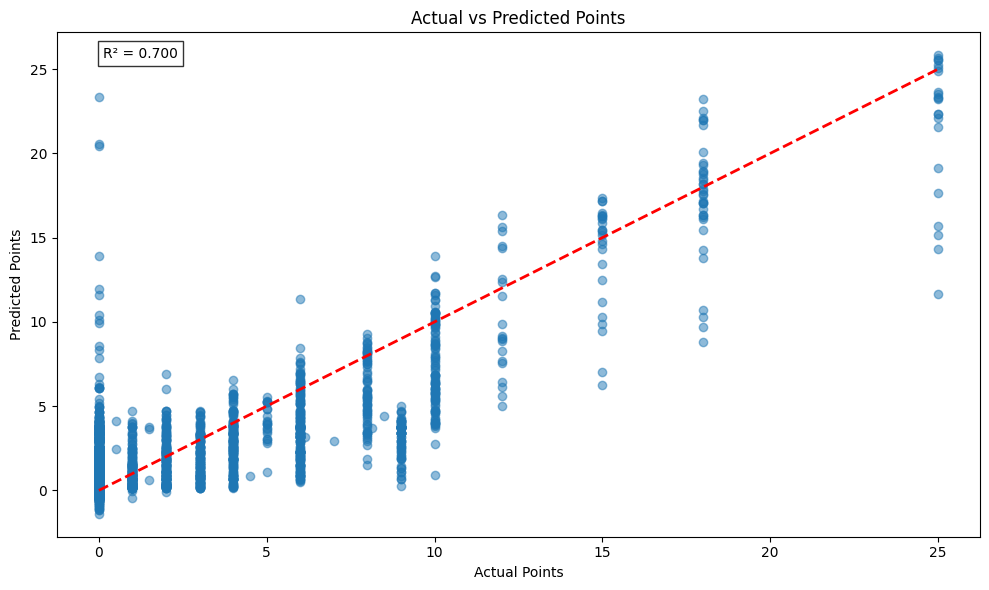

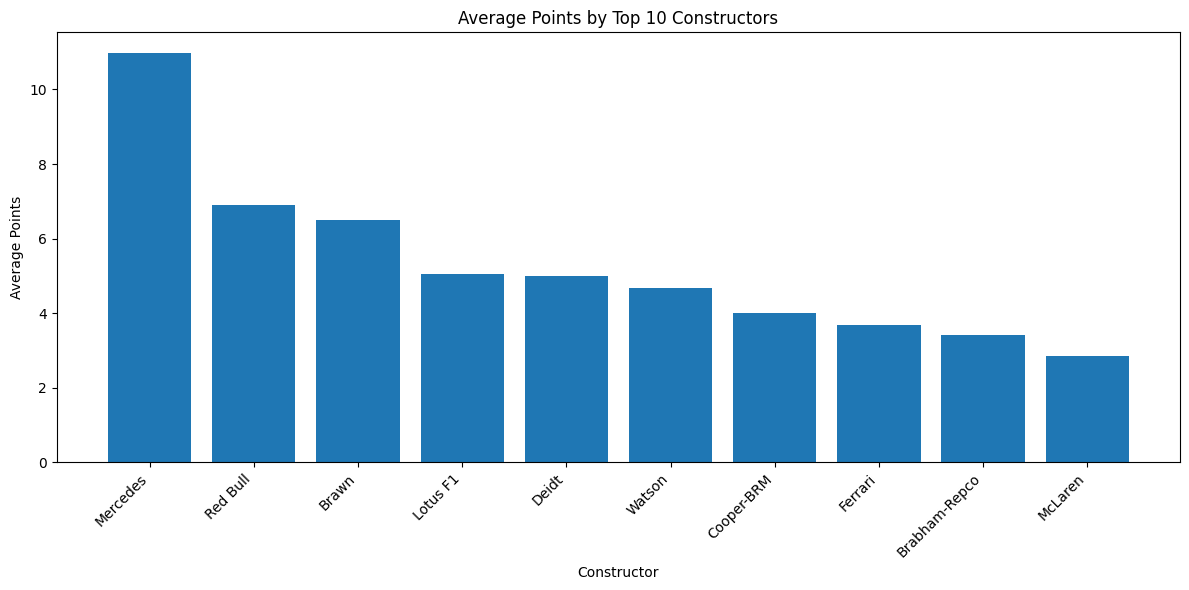

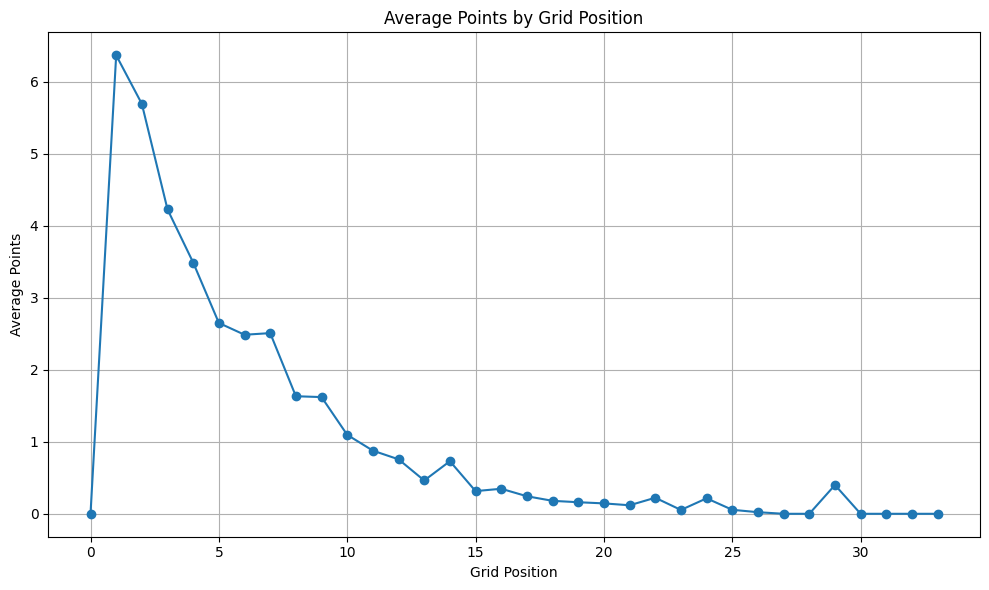

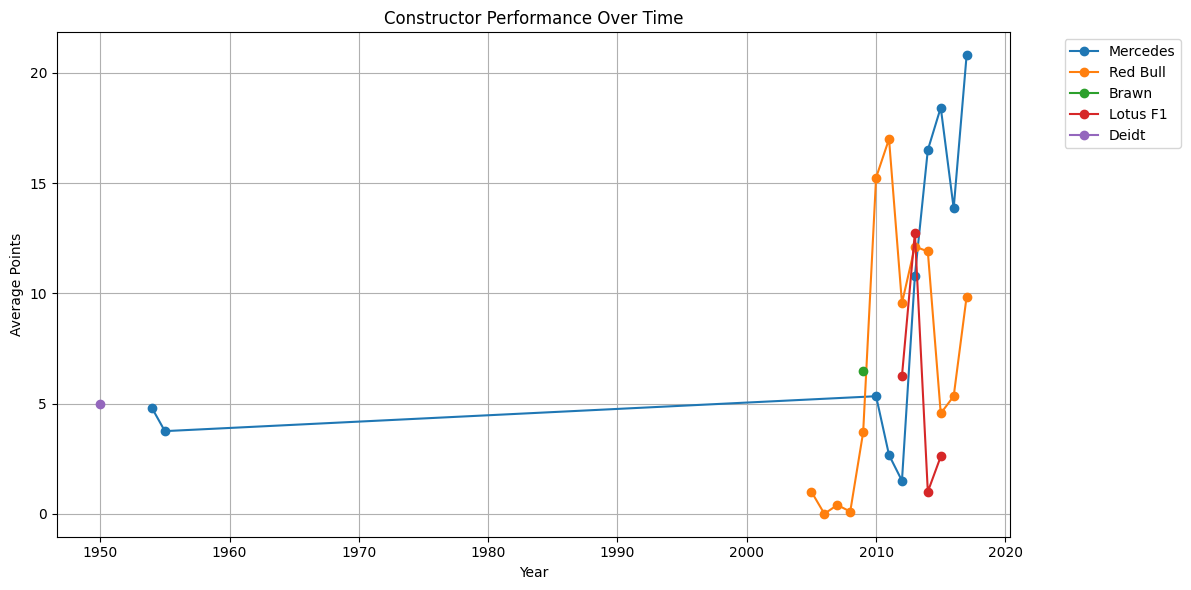

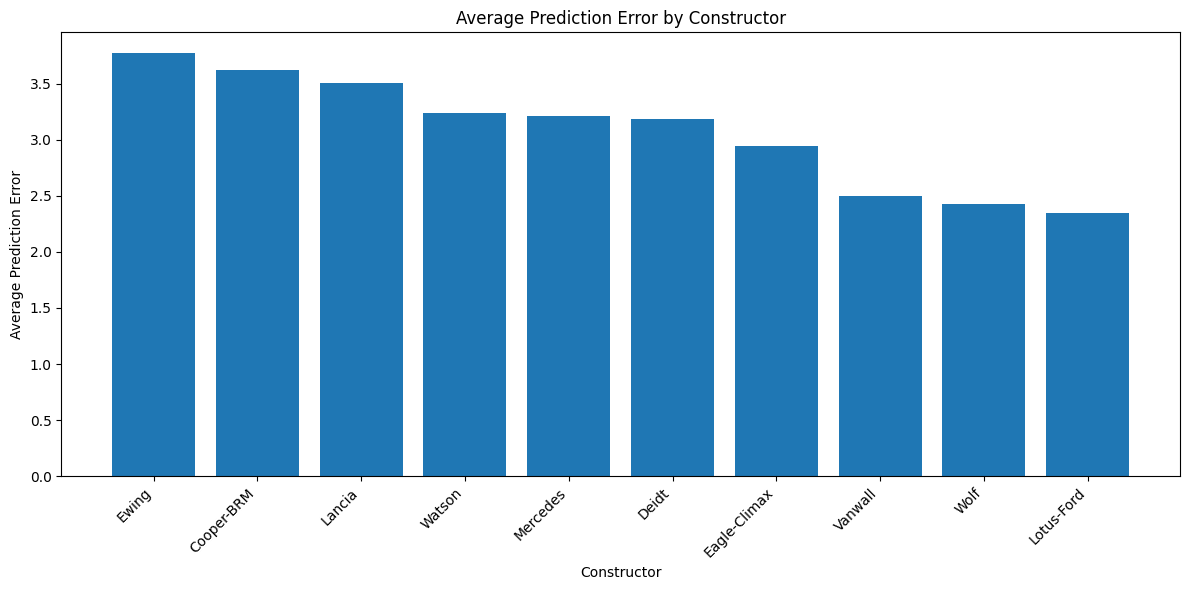

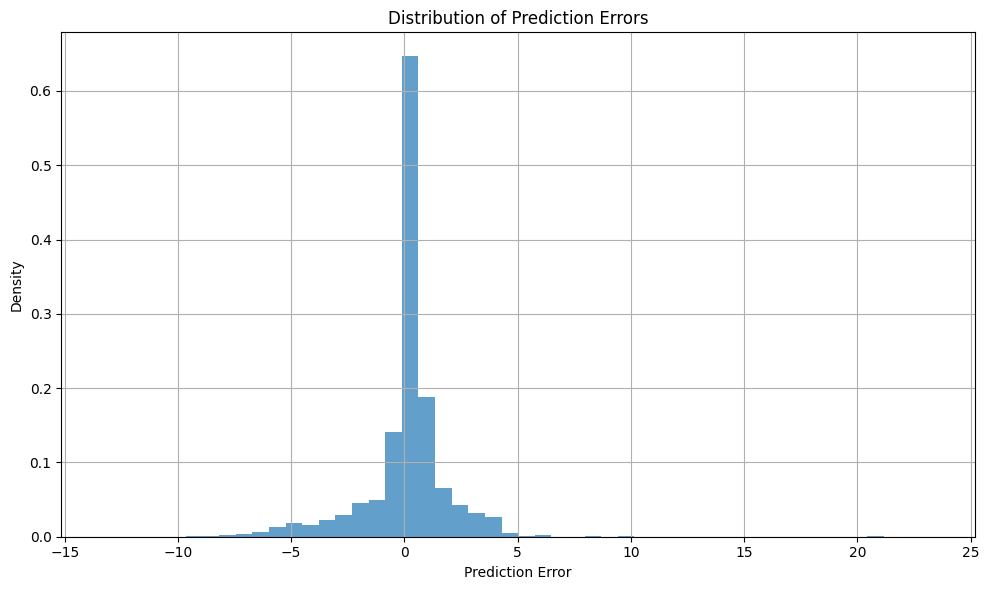


Top 10 Worst Predictions:
      Constructor Name  Year  Grid  Actual Points  Predicted Points  Difference
23259         Mercedes  2016     1          0.000            23.364      23.364
22320         Mercedes  2014     1          0.000            20.546      20.546
21883         Red Bull  2013     3          0.000            20.448      20.448
22729          Ferrari  2015     5          0.000            13.915      13.915
22259         Red Bull  2014     6         25.000            11.684      13.316
21300         Mercedes  2012     2          0.000            11.950      11.950
22828         Mercedes  2015     1          0.000            11.591      11.591
22831         Mercedes  2015     2         25.000            14.318      10.682
21058          McLaren  2011     2          0.000            10.393      10.393
1020           McLaren  2006     1          0.000            10.124      10.124

Constructor Performance Summary:
                  Race Count  Avg Points  Points Std  Avg E

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# First, generate predictions using the fitted pipeline
y_pred = fitted_pipeline.predict(X_test)

# Load constructors data if not already loaded
constructors = pd.read_csv("data/constructors.csv")

# Create comparison DataFrame with all necessary features
comparison_df = pd.DataFrame({
	'Actual Points': y_test,
	'Predicted Points': y_pred,
	'Difference': abs(y_test - y_pred),
	'Year': X_test['year'],
	'Grid': X_test['grid'],
	'Constructor': X_test['constructorId'],
	'Circuit': X_test['circuitId'],
	'Driver Age': X_test['driver_age'],
	'Qualifying Position': X_test['position_y'],
	'Pit Stops': X_test['pit_stop_count'],
	'Avg Pit Time': X_test['avg_pit_time'],
	'Avg Lap Time': X_test['avg_lap_time'],
	'Best Lap Time': X_test['best_lap_time'],
	'Lap Time Std': X_test['lap_time_std']
})

# Print some basic statistics about the predictions
print("\nModel Performance Metrics:")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"Mean Absolute Error: {abs(y_test - y_pred).mean():.3f}")
print(f"Max Error: {abs(y_test - y_pred).max():.3f}")

def plot_prediction_analysis(X_test, y_test, y_pred, comparison_df, constructors_df):
	"""
    Create a comprehensive set of visualizations for model analysis
    """
	# Create constructor ID to name mapping
	constructor_names = dict(zip(constructors_df['constructorId'], constructors_df['name']))

	# Add constructor names to the comparison DataFrame
	comparison_df['Constructor Name'] = comparison_df['Constructor'].map(constructor_names)

	# 1. Actual vs Predicted Points
	plt.figure(figsize=(10, 6))
	plt.scatter(y_test, y_pred, alpha=0.5)
	plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
	plt.xlabel('Actual Points')
	plt.ylabel('Predicted Points')
	plt.title('Actual vs Predicted Points')
	r2 = r2_score(y_test, y_pred)
	plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes,
			 bbox=dict(facecolor='white', alpha=0.8))
	plt.tight_layout()
	plt.show()

	# 2. Constructor Performance
	plt.figure(figsize=(12, 6))
	constructor_points = comparison_df.groupby('Constructor Name')['Actual Points'].mean().sort_values(ascending=False).head(10)
	plt.bar(range(len(constructor_points)), constructor_points.values)
	plt.xticks(range(len(constructor_points)), constructor_points.index, rotation=45, ha='right')
	plt.xlabel('Constructor')
	plt.ylabel('Average Points')
	plt.title('Average Points by Top 10 Constructors')
	plt.tight_layout()
	plt.show()

	# 3. Points by Grid Position
	plt.figure(figsize=(10, 6))
	grid_data = comparison_df.groupby('Grid')['Actual Points'].mean().reset_index()
	plt.plot(grid_data['Grid'], grid_data['Actual Points'], marker='o')
	plt.xlabel('Grid Position')
	plt.ylabel('Average Points')
	plt.title('Average Points by Grid Position')
	plt.grid(True)
	plt.tight_layout()
	plt.show()

	# 4. Constructor Performance Over Time
	plt.figure(figsize=(12, 6))
	top_constructors = constructor_points.head().index
	for constructor in top_constructors:
		constructor_yearly = comparison_df[comparison_df['Constructor Name'] == constructor].groupby('Year')['Actual Points'].mean()
		plt.plot(constructor_yearly.index, constructor_yearly.values, marker='o', label=constructor)

	plt.xlabel('Year')
	plt.ylabel('Average Points')
	plt.title('Constructor Performance Over Time')
	plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
	plt.grid(True)
	plt.tight_layout()
	plt.show()

	# 5. Prediction Errors by Constructor
	plt.figure(figsize=(12, 6))
	error_by_constructor = comparison_df.groupby('Constructor Name')['Difference'].mean().sort_values(ascending=False).head(10)
	plt.bar(range(len(error_by_constructor)), error_by_constructor.values)
	plt.xticks(range(len(error_by_constructor)), error_by_constructor.index, rotation=45, ha='right')
	plt.xlabel('Constructor')
	plt.ylabel('Average Prediction Error')
	plt.title('Average Prediction Error by Constructor')
	plt.tight_layout()
	plt.show()

	# 6. Prediction Error Distribution
	plt.figure(figsize=(10, 6))
	plt.hist(y_pred - y_test, bins=50, density=True, alpha=0.7)
	plt.xlabel('Prediction Error')
	plt.ylabel('Density')
	plt.title('Distribution of Prediction Errors')
	plt.grid(True)
	plt.tight_layout()
	plt.show()

# Generate the visualizations
plot_prediction_analysis(X_test, y_test, y_pred, comparison_df, constructors)

# Print top 10 worst predictions
print("\nTop 10 Worst Predictions:")
worst_predictions = comparison_df.sort_values('Difference', ascending=False).head(10)
print(worst_predictions[['Constructor Name', 'Year', 'Grid', 'Actual Points',
						 'Predicted Points', 'Difference']].to_string())

# Print constructor performance summary
print("\nConstructor Performance Summary:")
constructor_summary = comparison_df.groupby('Constructor Name').agg({
	'Actual Points': ['count', 'mean', 'std'],
	'Difference': 'mean'
}).round(2)
constructor_summary.columns = ['Race Count', 'Avg Points', 'Points Std', 'Avg Error']
print(constructor_summary.sort_values('Avg Points', ascending=False).head(10).to_string())